## 空间嵌入的加权有向网络拆解实验（随机攻击与）
🔑背景：有向性和权重在网络建模中都是非常重要的因素。 方向性体现的是“流动限制”，不是所有的路径都是可逆的。 权重决定负载，可靠性、成本，影响攻击后功能性稳定程度。所以在研究现实网络韧性时，有向加权模型才是必要的真实建模方式。
为了更加拟合加权有向图的网络拆解，不仅要考虑权重，即边的强度、距离或者是容量，还要考虑方向性，即信息/影响力只沿着某一方向传播，目标通常是最小化拆解后最大强连通分量或整体连通性。

🎯定义：有向加权网络的拆解是结构韧性研究中的“目标性攻击”与“故障模拟”，即网络在面对节点/边丧失时，维持其结构完整性或功能能力的能力。有向加权网络的拆解研究，是网络韧性研究中关于“方向性控制”和“传输功能”恢复能力的核心问题，兼具理论深度和实际应用价值，尤其适用于真实复杂系统建模与防御设计。

🔧难点：有向图的路径性质比无向图复杂得多：强连通与弱连通之间如何取舍

空间嵌入有向加权随机网络建模

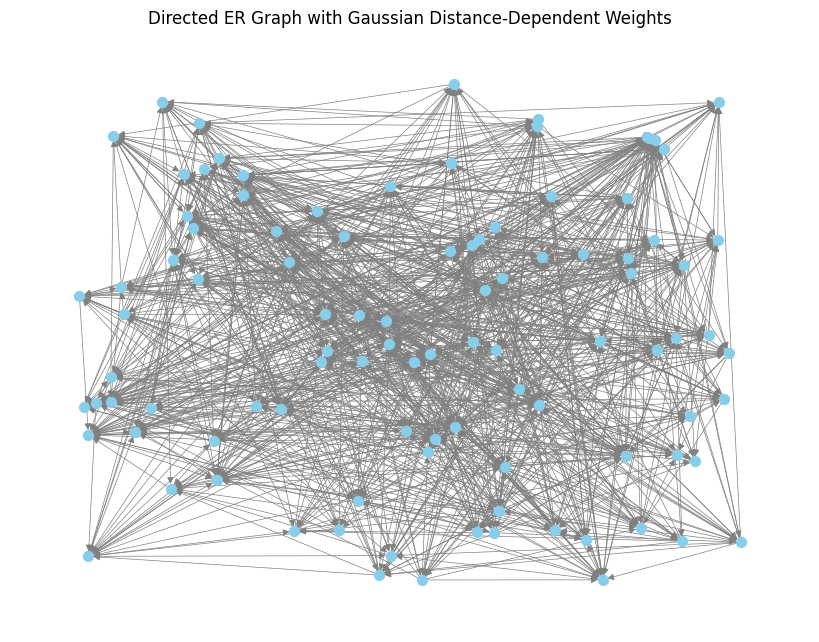

In [45]:
import numpy as np
import networkx as nx

def generate_gaussian_weighted_er(n, p, dim=2, mu_scale=1.0, sigma=0.1, pos_scale=1.0, avoid_self_loops=True):
    """
    生成有向加权ER网络，权重服从高斯分布且与欧氏距离相关。
    
    参数:
        n: 节点数
        p: 边生成概率
        dim: 欧氏空间维度
        mu_scale: 权重均值缩放因子（默认1.0）
        sigma: 高斯分布标准差（默认0.1）
        pos_scale: 节点坐标范围（默认1.0）
        avoid_self_loops: 是否避免自环（默认True）
    
    返回:
        G: networkx有向图
        pos: 节点坐标字典 {node: [x, y, ...]}
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    
    # 1. 生成节点坐标（避免重叠）
    pos = {}
    for i in range(n):
        while True:
            x = pos_scale * np.random.rand(dim)
            # 检查是否与已有节点重叠（如果avoid_self_loops=True）
            too_close = False
            for j in pos:
                if np.linalg.norm(x - pos[j]) < 1e-6:
                    too_close = True
                    break
            if not too_close:
                pos[i] = x
                break
    
    # 2. 生成ER随机边并分配高斯权重
    for i in range(n):
        for j in range(n):
            if avoid_self_loops and i == j:
                continue  # 跳过自环
            if np.random.rand() < p:
                d_ij = np.linalg.norm(pos[i] - pos[j])
                # 权重均值与距离逆相关（可调整公式）
                mu = mu_scale / (d_ij + 1e-6)
                # 从截断高斯分布采样权重（避免负值）
                weight = np.random.normal(mu, sigma)
                while weight <= 0:  # 确保权重为正
                    weight = np.random.normal(mu, sigma)
                G.add_edge(i, j, weight=weight)
    
    return G, pos

# 示例生成
n = 100
p = 0.1
G, pos = generate_gaussian_weighted_er(n, p, dim=2, mu_scale=1.0, sigma=0.2)

# 可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_size=50, node_color='skyblue', 
        edge_color='gray', width=0.5, arrows=True)
plt.title("Directed ER Graph with Gaussian Distance-Dependent Weights")
plt.show()

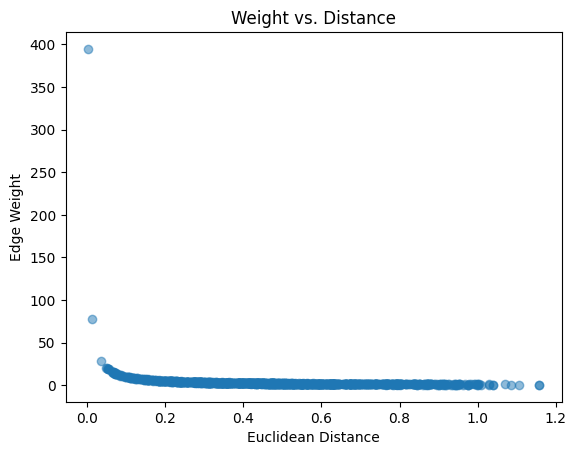

In [46]:
# 检查权重分布和距离相关性
weights = [G[i][j]['weight'] for i, j in G.edges()]
distances = [np.linalg.norm(pos[i] - pos[j]) for i, j in G.edges()]

plt.scatter(distances, weights, alpha=0.5)
plt.xlabel("Euclidean Distance")
plt.ylabel("Edge Weight")
plt.title("Weight vs. Distance")
plt.show()

按照随机攻击（Random Attack）策略对有向加权欧氏空间ER网络进行拆解，并使用三种韧性评估指标（LCC大小、全局效率、空间碎片化）进行评估

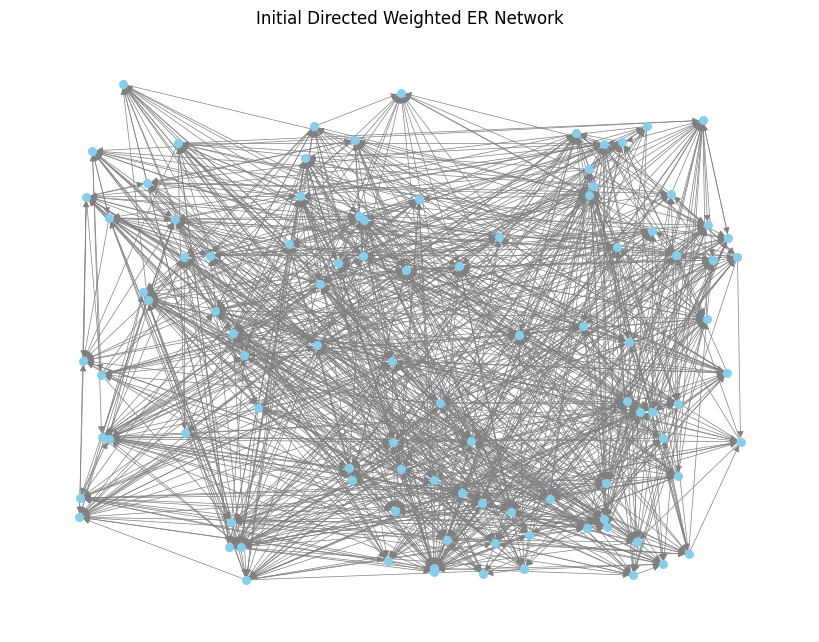

In [47]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 生成网络
n = 100  # 节点数
p = 0.1  # 边概率
dim = 2  # 欧氏空间维度
G, pos = generate_gaussian_weighted_er(n, p, dim=dim, mu_scale=1.0, sigma=0.2)

# 可视化初始网络
plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_size=30, node_color='skyblue', edge_color='gray', width=0.5, arrows=True)
plt.title("Initial Directed Weighted ER Network")
plt.show()

ER网络中有两个经典的临界值：

1. 连通性阈值:$E[M] = p \cdot \frac{N(N-1)}{2}$
2. 巨型连通分量出现阈值：$p = \frac{1}{N}$

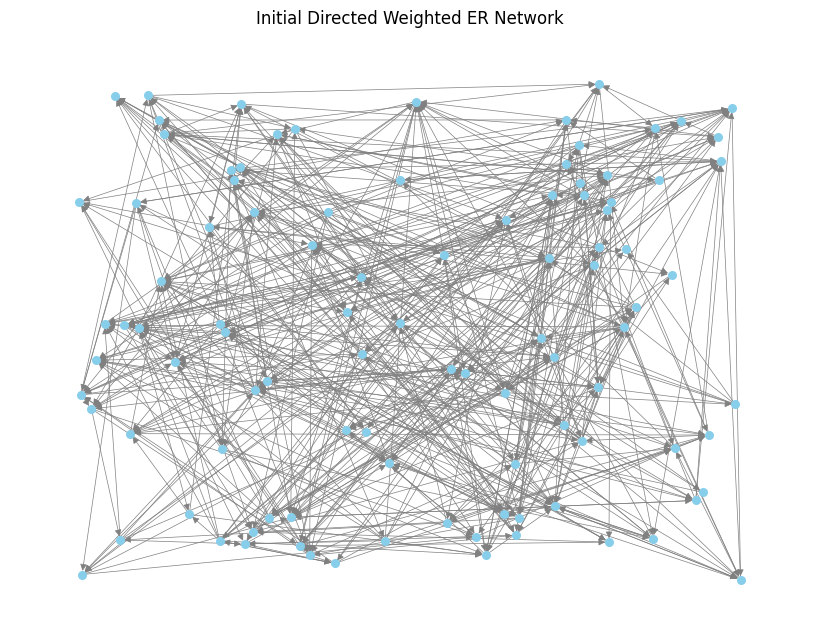

In [28]:
# 连通性阈值生成网络
n = 100  # 节点数
p =  np.log(n) / n # 边概率
dim = 2  # 欧氏空间维度
G, pos = generate_gaussian_weighted_er(n, p, dim=dim, mu_scale=1.0, sigma=0.2)

# 可视化初始网络
plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_size=30, node_color='skyblue', edge_color='gray', width=0.5, arrows=True)
plt.title("Initial Directed Weighted ER Network")
plt.show()

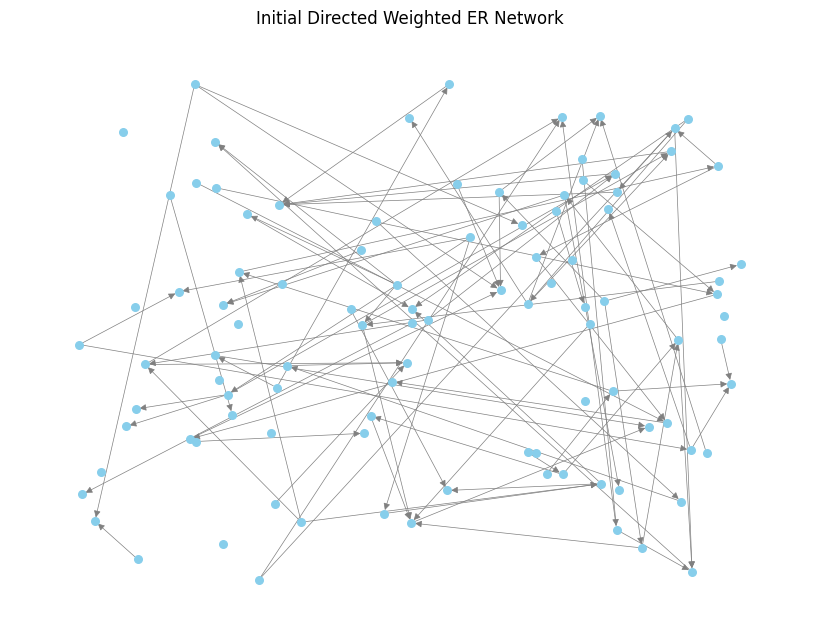

In [29]:
# 巨型连通分量出现阈值生成网络
n = 100  # 节点数
p = 1/n  # 边概率
dim = 2  # 欧氏空间维度
G, pos = generate_gaussian_weighted_er(n, p, dim=dim, mu_scale=1.0, sigma=0.2)

# 可视化初始网络
plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_size=30, node_color='skyblue', edge_color='gray', width=0.5, arrows=True)
plt.title("Initial Directed Weighted ER Network")
plt.show()

In [30]:
def random_attack_resilience(G, pos, steps=10):
    """
    随机攻击网络并评估韧性指标。
    
    参数:
        G: 输入网络（NetworkX有向图）
        pos: 节点坐标字典
        steps: 攻击步数（默认10步）
    
    返回:
        results: 字典，包含各步的LCC、全局效率、空间碎片化
        removal_order: 节点移除顺序（用于空间碎片化计算）
    """
    G = G.copy()
    n_nodes = len(G.nodes())
    removal_order = []
    results = {
        'lcc': [],
        'efficiency': [],
        'avg_distance': []
    }
    
    for _ in range(steps):
        # 随机选择并移除10%的节点
        nodes_to_remove = np.random.choice(G.nodes(), size=int(0.01 * n_nodes), replace=False)
        removal_order.append(nodes_to_remove)
        G.remove_nodes_from(nodes_to_remove)
        
        # 计算LCC（弱连通分量）
        lcc = max(len(c) for c in nx.weakly_connected_components(G)) / n_nodes
        results['lcc'].append(lcc)
        
        # 计算全局效率（处理全不连通情况）
        try:
            efficiency = nx.global_efficiency(G)
        except:
            efficiency = 0
        results['efficiency'].append(efficiency)
        
        # 计算剩余节点的平均欧氏距离
        remaining_nodes = list(G.nodes())
        if len(remaining_nodes) >= 2:
            coords = np.array([pos[n] for n in remaining_nodes])
            distances = np.linalg.norm(coords[:, None] - coords, axis=-1)
            avg_distance = np.mean(distances[np.triu_indices_from(distances, k=1)])
        else:
            avg_distance = 0
        results['avg_distance'].append(avg_distance)
    
    return results, removal_order

In [31]:
# 执行随机攻击（10步，每步移除1%节点）
results, removal_order = random_attack_resilience(G, pos, steps=99)

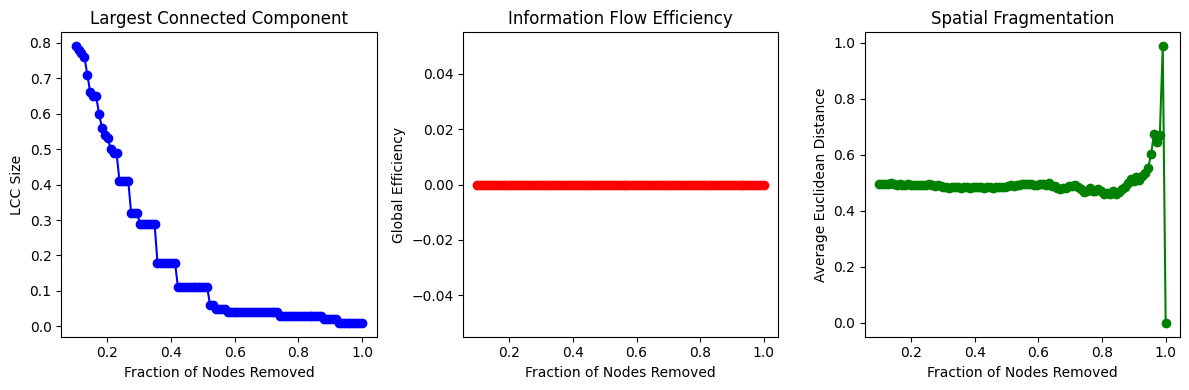

In [32]:
def plot_resilience_metrics(results):
    x = np.linspace(0.1, 1.0, len(results['lcc']))  # 横轴为移除比例
    
    plt.figure(figsize=(12, 4))
    
    # LCC大小
    plt.subplot(131)
    plt.plot(x, results['lcc'], marker='o', color='b')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("LCC Size")
    plt.title("Largest Connected Component")
    
    # 全局效率
    plt.subplot(132)
    plt.plot(x, results['efficiency'], marker='o', color='r')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Global Efficiency")
    plt.title("Information Flow Efficiency")
    
    # 空间碎片化
    plt.subplot(133)
    plt.plot(x, results['avg_distance'], marker='o', color='g')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Euclidean Distance")
    plt.title("Spatial Fragmentation")
    
    plt.tight_layout()
    plt.show()

plot_resilience_metrics(results)

按照加权度攻击策略对有向加权欧氏空间ER网络进行拆解，并使用三种韧性评估指标（LCC大小、全局效率、空间碎片化）进行评估

加权度定义：
对于有向网络，节点的加权度分为：

加权出度（Out-weighted Degree）：所有出边权重之和，反映节点的“影响力”。

加权入度（In-weighted Degree）：所有入边权重之和，反映节点的“依赖度”。

攻击策略：
优先移除加权出度最高的节点（假设攻击信息源或控制中心）。

In [33]:
import numpy as np
import networkx as nx

# 生成有向加权欧氏空间ER网络
n = 100  # 节点数
p = 0.1  # 边概率
dim = 2  # 空间维度
G, pos = generate_gaussian_weighted_er(n, p, dim=dim, mu_scale=1.0, sigma=0.2)

In [34]:
def weighted_degree_attack(G, pos, steps=10, attack_type='out'):
    """
    加权度攻击策略（默认攻击加权出度最高的节点），包含空序列保护
    
    参数:
        G: 输入网络（NetworkX有向图）
        pos: 节点坐标字典
        steps: 攻击步数
        attack_type: 'out'（出度）或 'in'（入度）
    
    返回:
        results: 字典，包含LCC、全局效率、空间碎片化
        removal_order: 节点移除顺序
    """
    G = G.copy()
    n_nodes = len(G.nodes())
    removal_order = []
    results = {
        'lcc': [],          # 最大弱连通分量比例
        'efficiency': [],    # 全局效率
        'avg_distance': []   # 平均欧氏距离
    }
    
    for _ in range(steps):
        # 计算当前加权度（出度或入度）
        if attack_type == 'out':
            degrees = dict(G.out_degree(weight='weight'))
        else:
            degrees = dict(G.in_degree(weight='weight'))
        
        # 选择加权度最高的1%节点移除
        nodes_to_remove = sorted(degrees.keys(), key=lambda x: -degrees[x])[:int(0.01 * n_nodes)]
        removal_order.append(nodes_to_remove)
        G.remove_nodes_from(nodes_to_remove)
        
        # 1. 计算LCC大小（弱连通分量），添加空序列保护
        components = list(nx.weakly_connected_components(G))
        if components:  # 确保components不为空
            lcc = max(len(c) for c in components) / n_nodes
        else:
            lcc = 0  # 所有节点已被移除
        results['lcc'].append(lcc)
        
        # 2. 计算全局效率（添加异常处理）
        try:
            efficiency = nx.global_efficiency(G) if len(G) > 1 else 0
        except:
            efficiency = 0
        results['efficiency'].append(efficiency)
        
        # 3. 计算空间碎片化（剩余节点平均距离）
        remaining_nodes = list(G.nodes())
        if len(remaining_nodes) >= 2:
            coords = np.array([pos[n] for n in remaining_nodes])
            distances = np.linalg.norm(coords[:, None] - coords, axis=-1)
            avg_distance = np.mean(distances[np.triu_indices_from(distances, k=1)])
        else:
            avg_distance = 0
        results['avg_distance'].append(avg_distance)
    
    return results, removal_order

In [35]:
# 生成网络
G, pos = generate_gaussian_weighted_er(n=100, p = 0.1, dim=3, mu_scale=1.0, sigma=0.2)
# 执行攻击评估
results, removal_order = weighted_degree_attack(G, pos, steps=100)

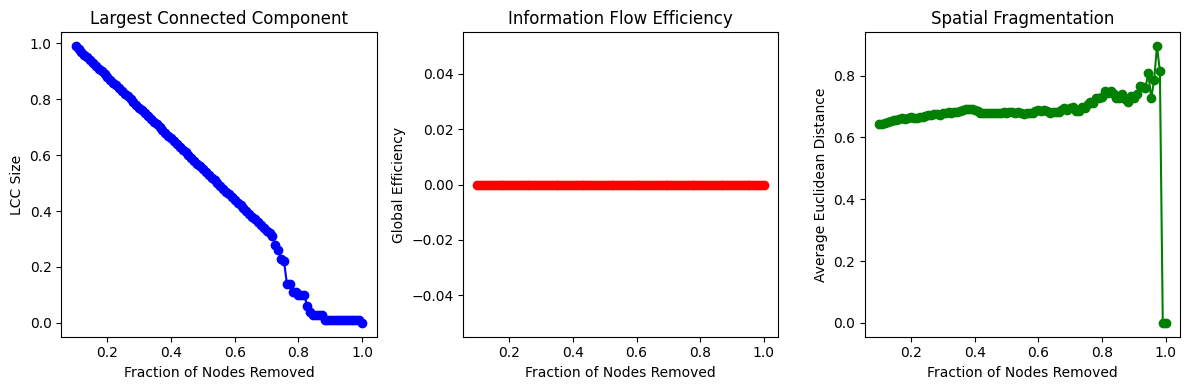

In [36]:
def plot_resilience_metrics(results):
    x = np.linspace(0.1, 1.0, len(results['lcc']))  # 横轴为移除比例
    
    plt.figure(figsize=(12, 4))
    
    # LCC大小
    plt.subplot(131)
    plt.plot(x, results['lcc'], marker='o', color='b')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("LCC Size")
    plt.title("Largest Connected Component")
    
    # 全局效率
    plt.subplot(132)
    plt.plot(x, results['efficiency'], marker='o', color='r')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Global Efficiency")
    plt.title("Information Flow Efficiency")
    
    # 空间碎片化
    plt.subplot(133)
    plt.plot(x, results['avg_distance'], marker='o', color='g')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Euclidean Distance")
    plt.title("Spatial Fragmentation")
    
    plt.tight_layout()
    plt.show()

plot_resilience_metrics(results)

按照加权度攻击策略对有向加权欧氏空间WS网络进行拆解，并使用三种韧性评估指标（LCC大小、全局效率、空间碎片化）进行评估

In [37]:
import numpy as np
import networkx as nx
from itertools import combinations

def generate_directed_ws_euclidean(n, k, p, dim=2, mu_scale=1.0, sigma=0.2):
    """
    生成有向加权欧氏空间WS网络
    
    参数:
        n: 节点数
        k: 初始每个节点的近邻连接数（偶数）
        p: 边重连概率
        dim: 欧氏空间维度
        mu_scale, sigma: 权重生成参数（高斯分布）
    
    返回:
        G: 有向加权WS网络（NetworkX DiGraph）
        pos: 节点坐标字典
    """
    # 1. 生成环形初始拓扑（无向）
    G = nx.watts_strogatz_graph(n, k, p, seed=42)
    G = nx.DiGraph(G)  # 转换为有向图
    
    # 2. 在欧氏空间中随机分配节点坐标
    pos = {i: np.random.rand(dim) for i in range(n)}
    
    # 3. 为所有边分配权重（基于距离的高斯分布）
    for u, v in G.edges():
        d = np.linalg.norm(pos[u] - pos[v])
        mu = mu_scale / (d + 1e-6)  # 避免除零
        weight = np.random.normal(mu, sigma)
        while weight <= 0:  # 确保权重为正
            weight = np.random.normal(mu, sigma)
        G.edges[u, v]['weight'] = weight
    
    # 4. 随机添加一些长程边（增强小世界特性）
    for u, v in combinations(range(n), 2):
        if (u, v) not in G.edges() and np.random.rand() < p:
            d = np.linalg.norm(pos[u] - pos[v])
            mu = mu_scale / (d + 1e-6)
            weight = np.random.normal(mu, sigma)
            G.add_edge(u, v, weight=weight)
    
    return G, pos

# 示例：生成网络
n, k, p = 100, 6, 0.2
G, pos = generate_directed_ws_euclidean(n, k, p, dim=2, mu_scale=1.0, sigma=0.2)

In [38]:
def weighted_degree_attack(G, pos, steps=10, attack_type='out'):
    """
    加权度攻击拆解网络
    
    参数:
        G: 输入网络（NetworkX DiGraph）
        pos: 节点坐标字典
        steps: 攻击步数
        attack_type: 'out'（出度）或 'in'（入度）
    
    返回:
        results: 字典，包含LCC、全局效率、空间碎片化
        removal_order: 节点移除顺序
    """
    G = G.copy()
    n_nodes = len(G.nodes())
    removal_order = []
    results = {
        'lcc': [],          # 最大弱连通分量比例
        'efficiency': [],    # 全局效率
        'avg_distance': []   # 平均欧氏距离
    }
    
    for _ in range(steps):
        # 1. 计算加权度（出度或入度）
        degrees = dict(G.out_degree(weight='weight')) if attack_type == 'out' else dict(G.in_degree(weight='weight'))
        
        # 2. 移除前10%的高加权度节点
        nodes_to_remove = sorted(degrees.keys(), key=lambda x: -degrees[x])[:int(0.01 * n_nodes)]
        removal_order.append(nodes_to_remove)
        G.remove_nodes_from(nodes_to_remove)
        
        # 3. 计算韧性指标
        # 3.1 LCC大小（弱连通分量）
        components = list(nx.weakly_connected_components(G))
        lcc = max(len(c) for c in components) / n_nodes if components else 0
        results['lcc'].append(lcc)
        
        # 3.2 全局效率
        try:
            efficiency = nx.global_efficiency(G) if len(G) > 1 else 0
        except:
            efficiency = 0
        results['efficiency'].append(efficiency)
        
        # 3.3 空间碎片化（剩余节点平均距离）
        remaining_nodes = list(G.nodes())
        if len(remaining_nodes) >= 2:
            coords = np.array([pos[n] for n in remaining_nodes])
            distances = np.linalg.norm(coords[:, None] - coords, axis=-1)
            avg_distance = np.mean(distances[np.triu_indices_from(distances, k=1)])
        else:
            avg_distance = 0
        results['avg_distance'].append(avg_distance)
    
    return results, removal_order

# 执行攻击
results, removal_order = weighted_degree_attack(G, pos, steps=100, attack_type='out')

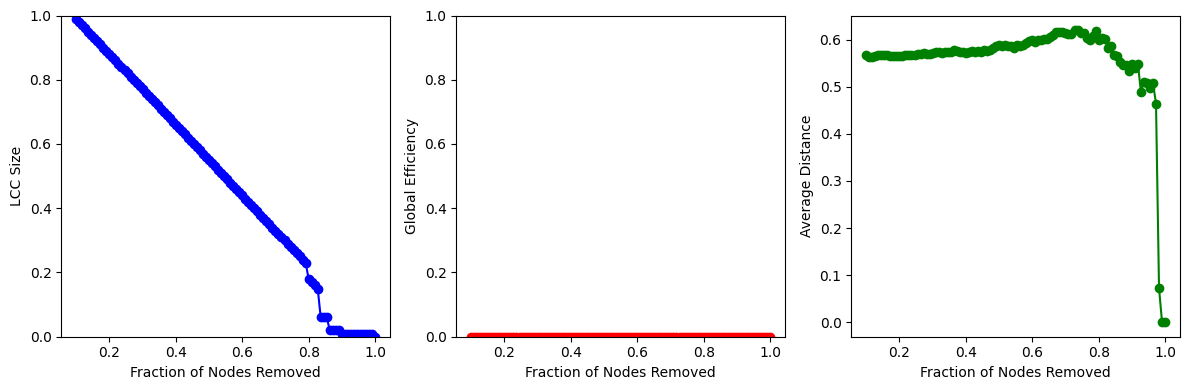

In [39]:
import matplotlib.pyplot as plt

def plot_resilience_metrics(results):
    x = np.linspace(0.1, 1.0, len(results['lcc']))
    
    plt.figure(figsize=(12, 4))
    
    # 1. LCC大小
    plt.subplot(131)
    plt.plot(x, results['lcc'], marker='o', color='b')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("LCC Size")
    plt.ylim(0, 1)
    
    # 2. 全局效率
    plt.subplot(132)
    plt.plot(x, results['efficiency'], marker='o', color='r')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Global Efficiency")
    plt.ylim(0, 1)
    
    # 3. 空间碎片化
    plt.subplot(133)
    plt.plot(x, results['avg_distance'], marker='o', color='g')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Distance")
    
    plt.tight_layout()
    plt.show()

plot_resilience_metrics(results)

加权度攻击能稳定削弱结构主干，但是在有向加权WS网络中，由于本身方向割裂，导致功能性（全局效率极低）而空间锻炼也非常显著。此类网络在功能韧性上表现脆弱，结构上略有稳固性。

按照加权度攻击策略对有向加权欧氏空间BA网络进行拆解，并使用三种韧性评估指标（LCC大小、全局效率、空间碎片化）进行评估

In [40]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [41]:
def generate_directed_ba_euclidean(n, m, dim=2, mu_scale=1.0, sigma=0.2):
    """
    生成有向加权欧氏空间BA无标度网络
    
    参数:
        n: 最终节点数量
        m: 每次新增节点时连接的边数
        dim: 欧氏空间维度（2或3）
        mu_scale: 权重均值缩放因子
        sigma: 权重高斯分布的标准差
    
    返回:
        G: 有向加权BA网络（NetworkX DiGraph）
        pos: 节点坐标字典
    """
    # 1. 生成无向BA网络（初始为m个节点的全连通图）
    G = nx.barabasi_albert_graph(n, m)
    G = nx.DiGraph(G)  # 转换为有向图
    
    # 2. 在欧氏空间中随机生成节点坐标
    pos = {i: np.random.rand(dim) for i in range(n)}
    
    # 3. 为边分配权重（基于距离的高斯分布）
    for u, v in G.edges():
        d = np.linalg.norm(pos[u] - pos[v])
        mu = mu_scale / (d + 1e-6)  # 避免除以零
        weight = np.abs(np.random.normal(mu, sigma))  # 确保权重为正
        G.edges[u, v]['weight'] = weight
        # 随机添加反向边（保持BA网络的有向性）
        if np.random.rand() > 0.5:
            G.add_edge(v, u, weight=np.abs(np.random.normal(mu, sigma)))
    
    return G, pos

In [42]:
def weighted_degree_attack(G, pos, steps=10, attack_type='out'):
    """
    加权度攻击策略拆解网络
    
    参数:
        G: 有向加权网络
        pos: 节点坐标字典
        steps: 攻击步数
        attack_type: 'out'（出度）或 'in'（入度）
    
    返回:
        results: 包含LCC、全局效率、空间碎片化的字典
        removal_order: 节点移除顺序
    """
    G = G.copy()
    n_nodes = len(G.nodes())
    removal_order = []
    results = {
        'lcc': [],          # 最大弱连通分量比例
        'efficiency': [],    # 全局效率
        'avg_distance': []   # 平均欧氏距离
    }
    
    for _ in range(steps):
        # 1. 计算加权出度或入度
        degrees = dict(G.out_degree(weight='weight')) if attack_type == 'out' else dict(G.in_degree(weight='weight'))
        
        # 2. 移除前10%的高加权度节点
        nodes_to_remove = sorted(degrees.keys(), key=lambda x: -degrees[x])[:int(0.01 * n_nodes)]
        removal_order.append(nodes_to_remove)
        G.remove_nodes_from(nodes_to_remove)
        
        # 3. 计算韧性指标
        # 3.1 LCC大小（弱连通分量）
        components = list(nx.weakly_connected_components(G))
        lcc = max(len(c) for c in components) / n_nodes if components else 0
        results['lcc'].append(lcc)
        
        # 3.2 全局效率（处理不连通情况）
        try:
            efficiency = nx.global_efficiency(G) if len(G) > 1 else 0
        except:
            efficiency = 0
        results['efficiency'].append(efficiency)
        
        # 3.3 空间碎片化（剩余节点平均距离）
        remaining_nodes = list(G.nodes())
        if len(remaining_nodes) >= 2:
            coords = np.array([pos[n] for n in remaining_nodes])
            distances = np.linalg.norm(coords[:, None] - coords, axis=-1)
            avg_distance = np.mean(distances[np.triu_indices_from(distances, k=1)])
        else:
            avg_distance = 0
        results['avg_distance'].append(avg_distance)
    
    return results, removal_order

In [43]:
def plot_resilience_metrics(results):
    """绘制三种韧性指标曲线"""
    x = np.linspace(0.1, 1.0, len(results['lcc']))
    
    plt.figure(figsize=(12, 4))
    
    # 1. LCC大小
    plt.subplot(131)
    plt.plot(x, results['lcc'], marker='o', color='b')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("LCC Size")
    plt.ylim(0, 1)
    
    # 2. 全局效率
    plt.subplot(132)
    plt.plot(x, results['efficiency'], marker='o', color='r')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Global Efficiency")
    plt.ylim(0, 1)
    
    # 3. 空间碎片化
    plt.subplot(133)
    plt.plot(x, results['avg_distance'], marker='o', color='g')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Distance")
    
    plt.tight_layout()
    plt.show()

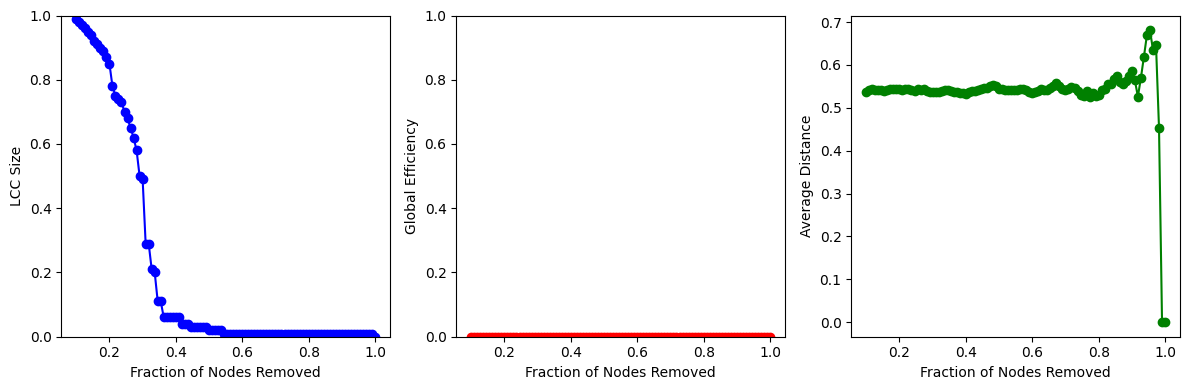

In [44]:
# 主程序
if __name__ == "__main__":
    # 1. 生成有向加权BA网络
    n, m = 100, 3  # 100个节点，每次新增连接3条边
    G, pos = generate_directed_ba_euclidean(n, m, dim=2, mu_scale=1.0, sigma=0.2)
    
    # 2. 执行加权出度攻击
    results, _ = weighted_degree_attack(G, pos, steps=100, attack_type='out')
    
    # 3. 可视化结果
    plot_resilience_metrics(results)